### Blue Book for Bulldozer - Kaggle Competition

This notebook is mostly created using the steps explained in the excellent Machine Learning course by Jeremy Howard and developed by Jeremy Howard and Rachel Thomas.  The courses are available at http://www.fast.ai/

The idea behind this notebook is to take the reader step by step of how to use RandomForest in any competition.  I have tried to clarify some aspects for a beginner and give reasons for some decision taken.

The high levels steps are as follows
1. Create the best model possible using only the training set (Train.csv)
    - Pre-process the training dataset and change all categories to codes, impute missing values and add some variables.
    - Split the dataset into training and validation sets (validation set being nearly the same size as the Kaggle provided   validation set. 
    - Separate the dependent variable.
    - Create the base model using all variables.
    - From the base model, find out the most important features and remove all unimportant features from the dataset.
    - Run the model again using only important features.
    - Detect and remove redundant features
    - Remove features which have a temporal sequence to make the model more general
2. Train the model on the whole training set
    - Run randomforest with a large number of entimators and finetuned paramters on the whole Kaggle provided training dataset.
    - This is the final model.
3. Apply the model on validation set (Valid.csv) and predict the SalePrice
    - Combine the Kaggle provided training and validation sets and pre-process the data.
    - Separate the datasets into training and validation and fit the above created model using the training data.
    - Predict the dependent variable using this fitted model.
4. Calculate the RMSLE using the actual SalePrice in the training set and the predicted SalePrice.

Notes:
1. I could not import the 'fastai' package into a Windows 10 environment and hence have included the 'fastai' functions I used in the notebook.
2. To run the notebook, the path to the dataset needs to be provided.
3. Further optimization of the model is possible by using the Machine_Appendix.csv which contains a more accurate year of manufacture and some more attributes.
4. Jeremy Howard also suggested using one-hot encoding of some variables.  This has not been included here.
5. The course by Jeremy stops at finding the RMSE score using a validation set derived from the training set.  I have used the actual validation set provided by Kaggle to calculate the final RMSE.  This is what Kaggle would do if you submit your preductions.

#### Environment Setup

Import necessary packages

In [84]:
import pandas as pd
import re
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import numpy as np
import math
from sklearn import metrics
from pandas.api.types import is_string_dtype, is_numeric_dtype
import matplotlib.pyplot as plt 
from sklearn.ensemble import forest
import scipy
from scipy.cluster import hierarchy as hc

#### Compile necessary fastai functions

In [85]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)
        
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1

#### Dataset import and pre-processing

In [86]:
df_raw = pd.read_csv('Train.csv', low_memory=False, parse_dates=['saledate'])

In [87]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
#Change SalePrice to log because the evaluation is for RMSLE
df_raw.SalePrice = np.log(df_raw.SalePrice)
#Change dates to date parts
add_datepart(df_raw, 'saledate')
#Add a column for age of bulldozer
df_raw['age'] = df_raw['saleYear'] - df_raw['YearMade'] 

In [89]:
#Change string variables to category type
train_cats(df_raw)
#Specify order for variable UsageBand and change to codes
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
df_raw.UsageBand = df_raw.UsageBand.cat.codes
#Change categories to code and missing values to 0, replace missing numeric values with median, 
#add column to indicate replaced missing values and separate the dependent variable as a separate df
df, y, nas = proc_df(df_raw, 'SalePrice')

In [90]:
df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,age,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,2,950,296,...,False,False,False,False,False,False,1163635200,2,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,2,1725,527,...,False,False,False,False,False,False,1080259200,8,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,0,331,110,...,False,False,False,False,False,False,1077753600,3,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,0,3674,1375,...,False,False,False,False,False,False,1305763200,10,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,1,4208,1529,...,False,False,False,False,False,False,1248307200,2,False,False


In [91]:
df.shape

(401125, 67)

#### Run the base model

In [92]:
#Split the dataset into training and validation sets. Use 12,000 as the validation set

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn) #for using unprocessed data if needed.
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [93]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((389125, 67), (12000, 67), (389125,), (12000,))

In [94]:
#Run base model
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m);

C:\Users\sureshsu\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.0908084299709318, 0.24578352609030657, 0.9827659574789724, 0.8921168757587268, -1.3018293967045298]


This model is pretty good and we are already in the top 25% of the leaderboard!

#### Feature Engineering

Various methods are used to remove unimportant and redundant features.  This not only simplifies the model but also improves the scores.

#### Feature importance

In [95]:
#Use the feature importance to find the most important ones
feature_importance = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : m.feature_importances_})
feature_importance.sort_values('Importance', ascending=False, inplace=True)
feature_importance.head(30)

,Feature,Importance
37,Coupler_System,0.198409
64,age,0.162049
14,fiProductClassDesc,0.140629
13,ProductSize,0.136602
2,ModelID,0.086065
5,YearMade,0.054311
10,fiSecondaryDesc,0.032405
63,saleElapsed,0.026305
8,fiModelDesc,0.024194
0,SalesID,0.019793


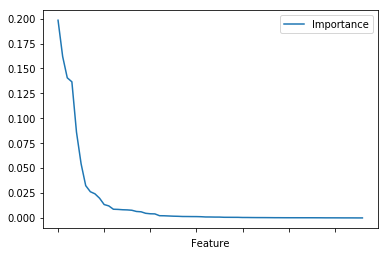

In [96]:
feature_importance.plot('Feature', 'Importance')

In [97]:
# Run the model for various cut off values for the importance to find the best set of importance features
for i in [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.011, 0.012]:
    important_features = feature_importance[feature_importance['Importance'] > i]
    df_important = df[important_features['Feature']]
    X_train, X_valid = split_vals(df_important, n_trn)
    y_train, y_valid = split_vals(y, n_trn)

    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print_score(m)


[0.11958432619003426, 0.22574406793833476, 0.9701129295238532, 0.9089917700653886, 0.9110722717807553]
[0.12049563941770408, 0.22521344572791402, 0.9696556745688437, 0.9094191056178855, 0.9106605721350212]
[0.12147071811939218, 0.22505634357621612, 0.9691625808353372, 0.9095454345765783, 0.9099832308914618]
[0.12163997253531515, 0.22516687691586804, 0.969076584708487, 0.909456561716612, 0.9098021466387117]
[0.12506905819081568, 0.22492477218285567, 0.9673085197916903, 0.9096511659165414, 0.9093439050845677]
[0.12492540750136373, 0.22312856564640468, 0.9673835736348412, 0.9110884213642689, 0.9095981573007454]
[0.12557639305226187, 0.22526850212388036, 0.9670427599482362, 0.9093748128169125, 0.9085874974712619]
[0.12703377677814198, 0.22586670449312324, 0.9662733468549793, 0.9088928618859209, 0.9086468555267551]
[0.13982977644922445, 0.22748791683229216, 0.9591366325656094, 0.9075802814655586, 0.9026764252171389]
[0.1397763420435576, 0.22785794064870832, 0.9591678575679768, 0.90727938364

In [102]:
#The best cut off point seems to be 0.0.006 when the RMSE score is 0.22312856564640468.
important_features = feature_importance[feature_importance['Importance'] > 0.006]
df_important = df[important_features['Feature']]
X_train, X_valid = split_vals(df_important, n_trn)
y_train, y_valid = split_vals(y, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)


[0.1250724684536177, 0.22574589686847144, 0.9673067369676975, 0.9089902954010024, 0.9092626050434348]


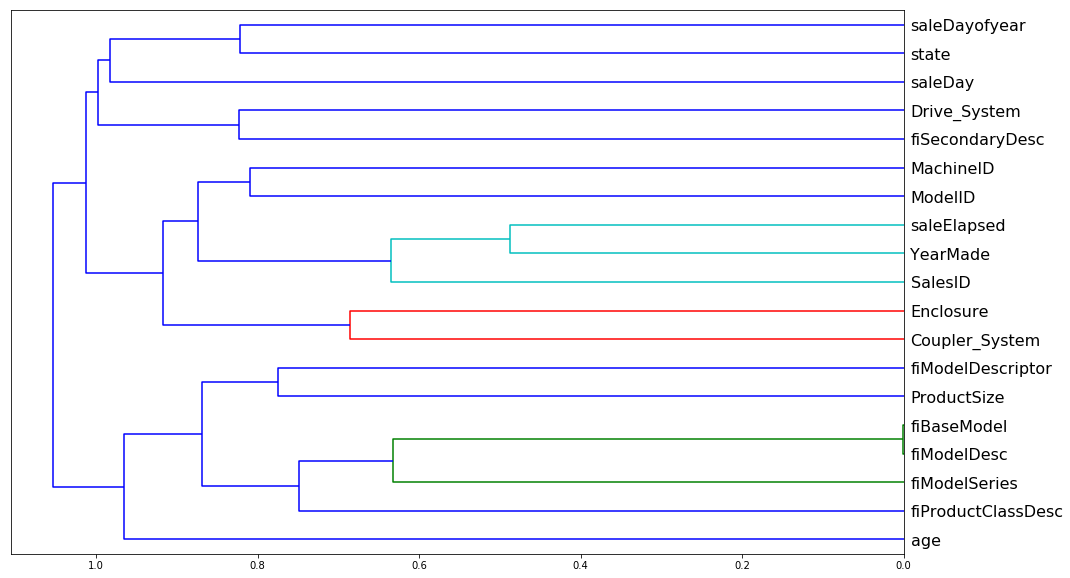

In [103]:
#Detect and remove redundant features
#Draw dendogram of feature clusters
corr = np.round(scipy.stats.spearmanr(df_important).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_important.columns, orientation='left', leaf_font_size=16)
plt.show()


In [104]:
#These feature pairs are in the same cluster'
cluster_pairs = ['saleDayofyear', 'state', 'Drive_System', 'fiSecondaryDesc', 'MachineID', 'ModelID', 'saleElapsed', 'YearMade', 'Enclosure', 'Coupler_System', 'fiModelDescriptor', 'ProductSize','fiBaseModel', 'fiModelDesc']
#Base OOB score
get_oob(df_important)

0.9080690969512725

In [106]:
#Get the OOB score after dropping each of the variables in the cluster pairs
for c in cluster_pairs:
    print(c, get_oob(df_important.drop(c, axis=1)))


saleDayofyear 0.906652296995623
state 0.9069376388210585
Drive_System 0.9069918364443399
fiSecondaryDesc 0.9058226111808125
MachineID 0.9090263081411097
ModelID 0.9073620274524163
saleElapsed 0.9021302468853822
YearMade 0.9075222798267965
Enclosure 0.9071869846567197
Coupler_System 0.9076748150212717
fiModelDescriptor 0.907722618507296
ProductSize 0.9048964672254667
fiBaseModel 0.9072082779412237
fiModelDesc 0.9073429977917062


In [108]:
#For each pair select the attribute which impacts the score less (score is higher) and remove it and calculate OOB
to_drop = ['state', 'Drive_System', 'MachineID', 'Coupler_System', 'fiModelDescriptor','fiModelDesc']
get_oob(df_important.drop(to_drop, axis=1))


0.9051640773213453

In [109]:
#OOB score has decreased slightly after removing attributes but model has become simpler.
#Run the random forest on the dataset after dropping the columns
df_keep = df_important.drop(to_drop, axis=1)
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)


[0.1345880561373964, 0.2307505977006369, 0.9621428542287741, 0.9049102636524801, 0.90639876771182]


In [110]:
df_keep.columns

Index(['age', 'fiProductClassDesc', 'ProductSize', 'ModelID', 'YearMade',
       'fiSecondaryDesc', 'saleElapsed', 'SalesID', 'fiBaseModel', 'Enclosure',
       'saleDayofyear', 'saleDay', 'fiModelSeries'],
      dtype='object')

In [111]:
#Remove time related features to generalize the model more
#Label the validation and training set and calculate the OOB score
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_


C:\Users\sureshsu\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


0.9999975070115301

In [112]:
#Very high OOB score
#Find the important features, i.e. the features which help rf predict the validation and training sets
feature_importance_ext = pd.DataFrame({'Feature' : x.columns, 'Importance' : m.feature_importances_})
feature_importance_ext.sort_values('Importance', ascending=False, inplace=True)
feature_importance_ext.head(30)


,Feature,Importance
7,SalesID,0.818795
6,saleElapsed,0.165247
4,YearMade,0.004877
10,saleDayofyear,0.004170
3,ModelID,0.001886
0,age,0.001536
8,fiBaseModel,0.001210
9,Enclosure,0.001184
11,saleDay,0.000442
1,fiProductClassDesc,0.000225


In [113]:
#Drop the top 1 and see if the RMSe improves
to_drop = ['SalesID']
df_keep = df_important.drop(to_drop, axis=1)
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)


[0.1275097246760018, 0.2218735477023768, 0.9660201511974527, 0.9120857998199207, 0.9092364278964402]


There is a slight improvement.

In [114]:
#Run the final model
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)


[0.07445680529666567, 0.21570860916579637, 0.9884137306018732, 0.9169034618469332, 0.9152102804880247]


The final model looks pretty good and the RMSE decreased from to 0.21570860916579637, mainly due to feature selection and fine tuning parameters.

What we have essentially done in the previous steps is to fine tune the hyper parameters and select the subset of features which gives the best score and generalizes the model the best. So the best model is RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True) and the features to use are df_keep.columns

#### Run model on actual validaiton set

Now lets train the model on the full training dataset and check the score on the validation set provided by Kaggle.

To get the same set of category codes and uniformly imputing missing values, we are joining the training and validation sets and pre-processing them together. After preprocessing we will separate them again

In [115]:
#Import data
df_raw = pd.read_csv('Train.csv', low_memory=False, parse_dates=['saledate'])
df_validation = pd.read_csv('Valid.csv', low_memory=False, parse_dates=['saledate'])


Just to be sure, check the column names and columns in the Training and validation sets.  

In [116]:
print('training shape',df_raw.shape)
print('validation shape', df_validation.shape)
print('difference between training and validaiton', set(df_raw.columns) - set(df_validation.columns))

training shape (401125, 53)
validation shape (11573, 52)
difference between training and validaiton {'SalePrice'}


In [117]:
#Separate out the SalePrice as y and change it to log and drop it from the training set
y = np.log(df_raw['SalePrice'])
df_raw = df_raw.drop('SalePrice', axis=1)

In [118]:
#Append the validation set to the training set
df_train_valid = df_raw.append(df_validation)


In [119]:
df_train_valid.shape

(412698, 52)

In [120]:
#Change dates to date parts
add_datepart(df_train_valid, 'saledate')

In [121]:
#Add a column for age of bulldozer
df_train_valid['age'] = df_train_valid['saleYear'] - df_train_valid['YearMade'] 


In [122]:
#Change string variables to category type
train_cats(df_train_valid)


In [123]:
#Specify order for variable UsageBand and change to codes
df_train_valid.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
df_train_valid.UsageBand = df_train_valid.UsageBand.cat.codes


In [124]:
#Change other categories into codes and replace NaNs with 0.
cat_cols = list(df_train_valid.select_dtypes(include=['category']).columns)  #Above UsageType is changed to Int 
for col in cat_cols:
    s = df_train_valid[col] 
    df_train_valid[col] = s.cat.codes+1

In [125]:
#Replace the NaNs for the numerical column with mean
df_train_valid['auctioneerID'].fillna(df_train_valid['auctioneerID'].median(), inplace=True)
df_train_valid['MachineHoursCurrentMeter'].fillna(df_train_valid['MachineHoursCurrentMeter'].median(), inplace=True)

In [126]:
#Check if df has NaNs
df_train_valid.isnull().sum()

SalesID                     0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
Enclosure                   0
Forks                       0
Pad_Type                    0
Ride_Control                0
Stick                       0
Transmission                0
Turbocharged                0
Blade_Extension             0
Blade_Width                 0
Enclosure_Type              0
Engine_Horsepower           0
                           ..
Tire_Size                   0
Coupler                     0
Coupler_Sy

In [127]:
df_train_valid.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,age
0,1139246,999089,3157,121,3.0,2004,68.0,2,963,298,...,3,320,False,False,False,False,False,False,1163635200,2
1,1139248,117657,77,121,3.0,1996,4640.0,2,1745,529,...,4,86,False,False,False,False,False,False,1080259200,8
2,1139249,434808,7009,121,3.0,2001,2838.0,0,336,111,...,3,57,False,False,False,False,False,False,1077753600,3
3,1139251,1026470,332,121,3.0,2001,3486.0,0,3716,1381,...,3,139,False,False,False,False,False,False,1305763200,10
4,1139253,1057373,17311,121,3.0,2007,722.0,1,4261,1538,...,3,204,False,False,False,False,False,False,1248307200,2


In [128]:
df_train_valid.shape

(412698, 65)

The pre-processed dataset is ready.  Now need to choose only columns which were in our final model and run the model.

In [129]:
# These were the columns in the final model
df_keep.columns

Index(['Coupler_System', 'age', 'fiProductClassDesc', 'ProductSize', 'ModelID',
       'YearMade', 'fiSecondaryDesc', 'saleElapsed', 'fiModelDesc',
       'fiBaseModel', 'MachineID', 'Drive_System', 'Enclosure', 'state',
       'saleDayofyear', 'saleDay', 'fiModelDescriptor', 'fiModelSeries'],
      dtype='object')

In [130]:
#Choose only columns which were used in the final model
df_train_valid = df_train_valid[df_keep.columns]

#Separate the training and validation sets
df_valid = df_train_valid.tail(11573)
df_train = df_train_valid.head(401125)


In [131]:
print(df_valid.shape)
print(df_train.shape)

(11573, 18)
(401125, 18)


In [132]:
#Train the model on training set and dependent variable using out final model
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(df_train, y) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [133]:
#Import the validation solution
solution = pd.read_csv('ValidSolution.csv', low_memory=False)
y_actual = np.log(solution.SalePrice)     

In [134]:
#Calculate the RMSE using the prediction from the validation set and the actual provided by Kaggle in the file 'ValidSolutions.csv'
rmse(m.predict(df_valid), y_actual)

0.24618093599623628

That's it! Further fine tuning can be done by selecting a differnt combinations of features and perhaps replacing YearMade with the corrected data.  I leave to the reader to do these and better the score above.  
Hope this notebook helped!